In [18]:
import json
from copy import deepcopy
from collections import defaultdict, Counter
from typing import Dict, Any, List, Tuple, Set
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import japanize_matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from beir.datasets.data_loader import GenericDataLoader
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pytrec_eval import RelevanceEvaluator
from tqdm import tqdm_notebook, tqdm

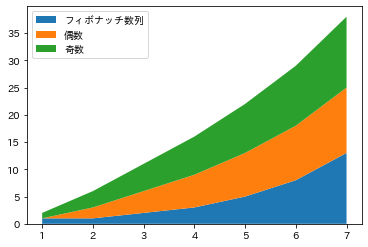

In [2]:
x = [1, 2, 3, 4, 5, 6, 7]
y1 = [1, 1, 2, 3, 5, 8, 13]
y2 = [0, 2, 4, 6, 8, 10, 12]
y3 = [1, 3, 5, 7, 9, 11, 13]

y = np.vstack([y1, y2, y3])

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3, labels=["フィボナッチ数列", "偶数", "奇数"])
ax.legend(loc=2)
plt.show()

In [3]:
MEDIAN = "median"
QUARTILE = "quartile"
Epsilon = 1e-03



class Binner:
    def binning(self, diff_rsj: Dict[str, Dict[str, float]]) -> pd.DataFrame:
        bin_rsj = self._binning()
        df_rsj_info_bin = self.gather_df(diff_rsj, bin_rsj)
        return df_rsj_info_bin
    
    def gather_df(self, diff_rsj: Dict[str, Dict[str, float]], bin_rsj: Dict[str, Dict[str, str]]) -> pd.DataFrame:
        rsj_info_bin = []
        for qid, diff_rsj_q in diff_rsj.items():
            for t in diff_rsj_q:
                rsj_info_bin.append((diff_rsj_q[t], bin_rsj[qid][t]))
        df_rsj_info_bin = pd.DataFrame(rsj_info_bin, columns=["ΔRSJ", "bin"])
        return df_rsj_info_bin
    
    def _binning(self):
        raise NotImplementedError


class RSJThresholdBinner(Binner):
    def __init__(self, rsj, rsj_threshold_type: str) -> None:
        self.rsj_threshold = self.rsj_threshold(rsj, rsj_threshold_type)
        self.rsj = rsj        
    
    def _binning(self) -> Dict[str, Dict[str, str]]:
        bin_rsj = {}
        for qid, rsj_uq in self.rsj.items():
            if qid not in bin_rsj:
                bin_rsj[qid] = defaultdict(float)
            for t, v in rsj_uq.items():
                if t not in rsj_uq:
                    bin_rsj[qid][t] = "OOV"
                    continue
                if rsj_uq[t] >= self.rsj_threshold:
                    bin_rsj[qid][t] = "HighRSJ"
                else:
                    bin_rsj[qid][t] = "LowRSJ"
        return bin_rsj    
    
    def rsj_threshold(self, rsj: Dict[str, Dict[str, float]], threshold_type: str) -> float:
        all_rsj_in_q = [v for qid, term_value in rsj.items() for t, v in term_value.items()],
        if threshold_type == MEDIAN:
            return np.median(all_rsj_in_q)
        elif threshold_type == QUARTILE:
            q75, q25 = np.percentile(all_rsj_in_q, [75, 25])
            return q75

        
class RSJIDFThresholdBinner(RSJThresholdBinner):
    def __init__(self, idf: Dict[str, float], rsj: Dict[str, Dict[str, float]], all_query_terms: Set[str], idf_threshold_type: str, rsj_threshold_type: str) -> float:
        self.rsj_threshold = self.rsj_threshold(rsj, rsj_threshold_type)
        self.idf_threshold = self.idf_threshold(idf, all_query_terms, idf_threshold_type)
        self.idf = idf
        self.rsj = rsj
    
    def _binning(self):
        bin_rsj = {}
        for t in self.idf:
            for qid, rsj_uq in self.rsj.items():
                if qid not in bin_rsj:
                    bin_rsj[qid] = defaultdict(float)
                if t not in rsj_uq:
                    bin_rsj[qid][t] = "OOV"
                    continue
                if self.idf[t] < self.idf_threshold:
                    if rsj_uq[t] > self.rsj_threshold:
                        bin_rsj[qid][t] = "HighRSJ:LowIDF"
                    else:
                        bin_rsj[qid][t] = "LowRSJ:LowIDF"
                else:
                    if rsj_uq[t] > self.rsj_threshold:
                        bin_rsj[qid][t] = "HighRSJ:HighIDF"
                    else:
                        bin_rsj[qid][t] = "LowRSJ:HighIDF"
        return bin_rsj
        
    def idf_threshold(self, idf: Dict[str, float], all_query_terms: Set[str], threshold_type: str) -> float:
        all_idf_in_q = [v for t, v in idf.items() if t in all_query_terms] 
        if threshold_type == MEDIAN:
            return np.median(all_idf_in_q)
        elif threshold_type == QUARTILE:
            q75, q25 = np.percentile(all_idf_in_q, [75, 25])
            return q75
        else:
            raise ValueError(f"{threshold_type} does not exist.")


class NumBinner(Binner):
    def __init__(self, rsj: Dict[str, Dict[str, float]], num: int = 4) -> None:
        self.rsj = rsj
        self.num = num
        
    def _binning(self) -> Dict[str, Dict[str, float]]:
        all_rsj_in_q = []
        all_qid = []
        all_t = []
        for qid, term_value in self.rsj.items():
            for t, v in term_value.items():
                all_qid.append(qid)
                all_t.append(t)
                all_rsj_in_q.append(v)
        
        bins = np.linspace(min(all_rsj_in_q), max(all_rsj_in_q), self.num)
        bins[-1] += Epsilon
        bined_rsj_in_q = np.digitize(all_rsj_in_q, bins)
        bin_names = {i+1: (round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)}
        named_bined_rsj_in_q = [bin_names[i] for i in bined_rsj_in_q]
        bin_rsj = {}
        for qid, t, name_bin in zip(all_qid, all_t, named_bined_rsj_in_q):
            if qid not in bin_rsj:
                bin_rsj[qid] = defaultdict(float)
            bin_rsj[qid][t] = name_bin
        return bin_rsj


In [4]:
class InvertedIndex:
    def __init__(self, corpus: Dict[str, Dict[str, str]], tokenizer: Any) -> None:
        self._n_doc = len(corpus)
        self.tokenizer = tokenizer
        self.index, self.df, self.idf = self._indexer(corpus, tokenizer)
        
    def _indexer(self, corpus: Dict[str, Dict[str, str]], tokenizer: Any) -> None:
        index_corpus = defaultdict(list)
        idf = defaultdict(float)
        for cid, doc in tqdm(corpus.items(), total=self._n_doc):
            text = doc["title"] + " " + doc["text"]
            t_doc = tokenizer(text)
            for t in set(t_doc):
                index_corpus[t].append(cid)
                
        df = {k: len(v) for k, v in index_corpus.items()}
                
        for v, freq in df.items():
            idf[v] = np.log(self.n_doc / freq)
        
        return index_corpus, df, idf
    
    @property
    def n_doc(self):
        return self._n_doc    

class RSJCalculator:
    def __init__(self, index: InvertedIndex, queries: Dict[str, str], qrels: Dict[str, Dict[str, int]]) -> None:
        self.index = index
        self.t_queries, self.all_query_terms = self.tokenize_queries(queries, qrels, index.tokenizer)
        rel_qrels = self._extract_rel(qrels)
        self.rsj = self._calc_rsj(self.t_queries, rel_qrels)
        
    def tokenize_queries(self, queries: Dict[str, str], qrels: Dict[str, Dict[str, int]], tokenizer: Any) -> Tuple[Dict[str, List[str]], Set[str]]:
        t_queries = {}
        all_query_terms = set()
        for qid, _ in qrels.items():
            try:
                query = queries[qid]
            except KeyError:
                continue
            t_query = tokenizer(query)
            t_queries[qid] = t_query
            all_query_terms |= set(t_query)
        return t_queries, all_query_terms
    
    def _extract_rel(self, qrels: Dict[str, Dict[str, int]]) -> Dict[str, Dict[str, int]]:
        rel_qrels = {}
        for qid, q_qrels in qrels.items():
            rel_q_qrels = {k: v for k, v in q_qrels.items() if v > 0}
            rel_qrels[qid] = rel_q_qrels
        return rel_qrels
            
    def _calc_rsj(self, t_queries: Dict[str, List[str]], relqrels: Dict[str, Dict[str, int]]) -> Dict[str, Dict[str, float]]:
        rsj = defaultdict(float)
        for qid, q_qrels in relqrels.items():
            t_query = t_queries[qid]
            rel_q_qrels = {k: v for k, v in q_qrels.items() if v > 0}
            Nr = len([i for i in q_qrels.values() if i > 0])
            if Nr < 1:
                continue
            wtq = defaultdict(float)
            for t in t_query:
                Dt = self.index.index[t]
                Nt = len(Dt)
                Ntr = 0
                for did in Dt:
                    if did in rel_q_qrels:
                        Ntr+= 1
                    
                N = self.index.n_doc
                wtq[t] = np.log(((Ntr + 0.5)*(N - Nt - Nr + Ntr + 0.5))/((Nr - Ntr + 0.5)*(Nt - Ntr + 0.5)) )
            rsj[qid] = wtq
        return rsj
        
    def calc_diff_rsj(self, search_result: Dict[str, float], top_K: int =100) -> Dict[str, Dict[str, float]]:
        topK_rels = {}
        for qid, rels in search_result.items():
            topK_rels[qid] = dict(sorted(rels.items(), key=lambda x: -x[1])[:top_K])
            
        rsj_s = self._calc_rsj(self.t_queries, topK_rels)
        diff_rsj = defaultdict(dict)
        for qid in self.rsj:
            for t in self.t_queries[qid]:
                diff_rsj[qid][t] = rsj_s[qid][t] - self.rsj[qid][t]
                
        return diff_rsj
    
def analyze(search_result: Dict[str, Dict[str, float]], rsj_calculator: RSJCalculator, binner: Binner, top_K: int = 100) -> pd.DataFrame:
    diff_rsj = rsj_calculator.calc_diff_rsj(search_result, top_K=top_K)
    binned_rsj = binner.binning(diff_rsj)
    return binned_rsj

In [5]:
analyzer = Analyzer(get_lucene_analyzer())

In [6]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])

['STIXNonUnicode', 'STIXSizeFourSym', 'STIXSizeOneSym', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'cmr10', 'DejaVu Sans Display', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'STIXSizeOneSym', 'DejaVu Sans', 'STIXSizeFiveSym', 'cmsy10', 'STIXGeneral', 'STIXGeneral', 'DejaVu Sans', 'STIXNonUnicode', 'cmtt10', 'cmss10', 'DejaVu Sans Mono', 'STIXGeneral', 'DejaVu Serif', 'STIXNonUnicode', 'cmb10', 'STIXNonUnicode', 'DejaVu Sans Mono', 'cmmi10', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXSizeTwoSym', 'cmex10', 'DejaVu Serif', 'STIXSizeThreeSym', 'DejaVu Serif Display', 'DejaVu Sans', 'DejaVu Serif', 'Bitstream Vera Sans', 'Liberation Sans', 'DejaVu Serif', 'Bitstream Vera Sans', 'DejaVu Serif', 'Liberation Mono', 'Liberation Mono', 'DejaVu Sans', 'cmr10', 'DejaVu Serif', 'DejaVu Sans Mono', 'Liberation Serif', 'cmex10', 'Bitstream Vera Sans Mono', 'Bitstream Vera Sans Mono', 'msam10', 'DejaVu Sans', 'cmsy10', 'Liberation Sans Narrow', 'DejaV

In [7]:
plt.rcParams['font.family'] = 'IPAexGothic'
matplotlib.rcParams['font.family'] = 'IPAexGothic'
# fp = FontProperties(fname='/home/iida.h/download/IPAexfont00401/ipaexm.ttf')
# matplotlib.matplotlib_fname()
sns.set(font='IPAexGothic')
# print(plt.rcParams['font.family'])
# japanize_matplotlib.japanize()

In [8]:
dataset = "msmarco"
data_path = f"/home/gaia_data/iida.h/BEIR/datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

  0%|          | 0/8841823 [00:00<?, ?it/s]

In [9]:
index = InvertedIndex(corpus, analyzer.analyze)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 8841823/8841823 [11:41<00:00, 12597.48it/s]


In [10]:
rsj_calculator = RSJCalculator(index, queries, qrels)

In [11]:
with open("/home/gaia_data/iida.h/BEIR/C-BM25/results/msmarco/result/bm25/analysis.json") as f:
    bm25_result = json.load(f)

with open("/home/gaia_data/iida.h/BEIR/C-BM25/results/msmarco/result/cos_sim/mpnet-tod/analysis.json") as f:
    dense_result = json.load(f)

with open("/home/gaia_data/iida.h/BEIR/C-BM25/results/msmarco/result/dot/mpnet-v3-mse-beir-dot/analysis.json") as f:
    distil_dense_result = json.load(f)
    
binner = NumBinner(rsj_calculator.rsj, 5)

df_bin_bm25 = analyze(bm25_result, rsj_calculator, binner)
df_bin_dense = analyze(dense_result, rsj_calculator, binner)
df_bin_distil_dense = analyze(distil_dense_result, rsj_calculator, binner)

In [12]:
df_bin_bm25 = pd.concat([df_bin_bm25, pd.DataFrame({"retriever":["BM25"] * len(df_bin_bm25.index)})], axis=1)
df_bin_dense = pd.concat([df_bin_dense, pd.DataFrame({"retriever":["密ベクトル検索"] * len(df_bin_dense.index)})], axis=1)
df_bin_distil_dense = pd.concat([df_bin_distil_dense, pd.DataFrame({"retriever":["密ベクトル検索（蒸留）"] * len(df_bin_distil_dense.index)})], axis=1)
df_result = pd.concat([df_bin_bm25, df_bin_dense, df_bin_distil_dense])

In [13]:
print(matplotlib.get_configdir())


/home/iida.h/.config/matplotlib


/tmp/ipykernel_1613319/2544906557.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)


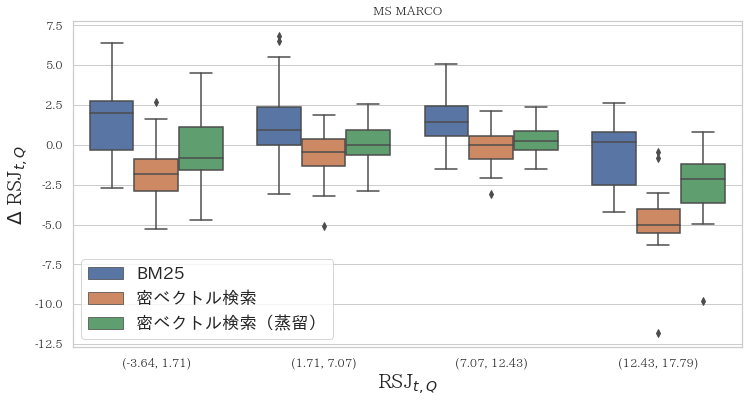

<Figure size 432x288 with 0 Axes>

In [16]:
bin_names = df_result["bin"].unique()
bin_names = sorted(bin_names, key=lambda x: x[0])
fig, ax = plt.subplots(figsize=(12, 6))
fp = FontProperties(fname='/home/iida.h/download/IPAexfont00401/ipaexm.ttf')
sns.set_style(style="whitegrid")
plt.rcParams['font.family'] = 'IPAexGothic'
matplotlib.rcParams['font.family'] = 'IPAexGothic'
# sns.set(font='IPAexGothic')
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_result, ax=ax)
p.set_title("MS MARCO", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
p.set_xlabel("RSJ$_{t, Q}$", fontsize=20, fontproperties=fp)
p.set_ylabel("$\Delta$ RSJ$_{t, Q}$", fontsize=20, fontproperties=fp)
# p.set_title("MS MARCO", fontsize=20)
# p.set_xticklabels(bin_names, fontsize=16)
# p.set_yticklabels(p.get_yticks(), fontsize=16)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20)
# p.set_xlabel("", fontsize=20)
# p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=20)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("rsj-dense-msmarco.svg", format="svg")

# IDF

In [20]:
index.idf["interact"]

5.464909425784678

In [21]:
index.idf["direct"]

4.158191948987143

In [19]:
pd.Series(list(index.idf.values())).describe()

count    2.660824e+06
mean     1.536147e+01
std      1.191025e+00
min      1.556821e+00
25%      1.530186e+01
50%      1.599500e+01
75%      1.599500e+01
max      1.599500e+01
dtype: float64

In [22]:
from transformers import AutoTokenizer

model_path="/home/gaia_data/iida.h/BEIR/C-BM25/model/distil/dense/"
hf_tokenizer = AutoTokenizer.from_pretrained(model_path)
index = InvertedIndex(corpus, hf_tokenizer.tokenize)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8841823/8841823 [49:42<00:00, 2964.27it/s]


In [23]:
print(index.idf["interaction"])
print(index.idf["direct"])
pd.Series(list(index.idf.values())).describe()

6.850482604133618
5.014229580583022


count    27647.000000
mean         8.158993
std          1.684436
min          0.016054
25%          7.091460
50%          8.240093
75%          9.315404
max         15.995004
dtype: float64